In [1]:
import pandas as pd
import shapely.wkt
from pyproj import Geod
from shapely import wkt
import numpy as np
import warnings
import keplergl
import numpy as np
import osmnx as ox
import pandas as pd
import matplotlib.colors as colors
import geopandas as gpd
import plotly.express as px
# from skgstat import Variogram
import matplotlib.pyplot as plt
from shapely.geometry import Point
# from tobler.area_weighted import area_interpolate
# Plotting defaults
plt.style.use('ggplot')
px.defaults.height = 400; px.defaults.width = 620
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.grid': False})

In [3]:
# To run on colab, uncomment this
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#TODO : Warnings are around deprecated use of certain APIs. Remove warnings and use non deprecated alternatives
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [65]:
parcel_pairs_df = pd.read_csv("data/sampledataset.csv")

In [6]:
parcel_pairs_df.info()
sample_pairs = len(parcel_pairs_df)
print(f"Started analysis with {sample_pairs} pairs")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      513 non-null    int64 
 1   Pair_a  513 non-null    object
 2   Pair_b  513 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.1+ KB
Started analysis with 513 pairs


In [7]:
parcel_pairs_df.describe(include="all")

,id,Pair_a,Pair_b
count,513.000000,513,513
unique,NaN,239,235
top,NaN,"POLYGON ((31.5180459009 1.6125885638, 31.51804...","POLYGON ((31.4562504180292 1.63284358914328, 3..."
freq,NaN,15,15
mean,262.881092,NaN,NaN
std,151.792787,NaN,NaN
min,0.000000,NaN,NaN
25%,130.000000,NaN,NaN
50%,266.000000,NaN,NaN
75%,394.000000,NaN,NaN


## Remove the duplicate rows

In [8]:
# There are a lot of rows with repeating (pair_a, pair_b) tuples. We are just going to keep one entry.
parcel_pairs_df = parcel_pairs_df.drop_duplicates(subset=['Pair_a', 'Pair_b'])
print(f"Pairs after de-duplication : {len(parcel_pairs_df)}")

Pairs after de-duplication : 295


In [9]:
# There are cases where a given parcel is being compared with itself and 
# in those cases we are going to have 100% overlap. I am not removing those considering-
# we want to analyse the cases which have complete overlap
self_comparison = parcel_pairs_df[parcel_pairs_df["Pair_a"]==parcel_pairs_df["Pair_b"]]
print(f"Self comparison parcels : {len(self_comparison)}")

Self comparison parcels : 182


In [10]:
self_comparison

,id,Pair_a,Pair_b
2,2,"POLYGON ((31.7216862920056 1.83134403943523, 3...","POLYGON ((31.7216862920056 1.83134403943523, 3..."
3,3,"POLYGON ((31.7023455560315 1.83796156365404, 3...","POLYGON ((31.7023455560315 1.83796156365404, 3..."
4,4,"POLYGON ((31.7061141722958 1.83877089201203, 3...","POLYGON ((31.7061141722958 1.83877089201203, 3..."
5,5,"POLYGON ((31.1106548645825 1.40846818571946, 3...","POLYGON ((31.1106548645825 1.40846818571946, 3..."
8,8,"POLYGON ((31.7252774618528 1.83009326642251, 3...","POLYGON ((31.7252774618528 1.83009326642251, 3..."
...,...,...,...
500,510,"POLYGON ((31.7250505760039 1.82536371478978, 3...","POLYGON ((31.7250505760039 1.82536371478978, 3..."
501,511,"POLYGON ((31.7242164944543 1.83436277179447, 3...","POLYGON ((31.7242164944543 1.83436277179447, 3..."
506,516,"POLYGON ((31.7259661596099 1.82984578654845, 3...","POLYGON ((31.7259661596099 1.82984578654845, 3..."
507,517,"POLYGON ((31.7238549270953 1.83305204935236, 3...","POLYGON ((31.7238549270953 1.83305204935236, 3..."


In [11]:
# parcel_list = (set(parcel_pairs_df['Pair_a'] + parcel_pairs_df['Pair_b']))
parcels = set()
for p in parcel_pairs_df['Pair_a']:
    parcels.add(str(p))
for p in parcel_pairs_df['Pair_b']:
    parcels.add(str(p))
parcel_list = list(parcels)    
print(f"Unique parcels in the list : {len(parcel_list)}")
indexes = np.arange(0, len(parcel_list))

Unique parcels in the list : 278


In [12]:
type(parcel_pairs_df['Pair_a'][0])

str

In [13]:
type(shapely.wkt.loads(parcel_pairs_df['Pair_a'][0]))

shapely.geometry.polygon.Polygon

In [14]:
# Convert to shapely from str

In [15]:
def convert_to_poly(x):
    return shapely.wkt.loads(x)
parcel_pairs_df['Poly_a'] = parcel_pairs_df['Pair_a'].apply(convert_to_poly)
parcel_pairs_df['Poly_b'] = parcel_pairs_df['Pair_b'].apply(convert_to_poly)

In [16]:
type(parcel_pairs_df['Poly_a'][0])

shapely.geometry.polygon.Polygon

# Create dataframes

In [17]:
## We are going to create 2 dataframes :
# One for keeping track of all individual parcels
# Second for keeping track of all pairs

In [18]:
parcels_df = pd.DataFrame(columns=['parcelId', 'geometry', 'centroid', 'area (m^2)', 'perimeter (m)', 'numConflicts','avgOverlapArea (m^2)'], index=indexes)
augmented_parcel_pairs_df = pd.DataFrame(columns=["pairId", "parcel1Id", "parcel2Id", "Area1 in m^2", "Area2 in m^2", "intersectionGeometry", "num_overlaps", "centroid", "IntersectionArea in m^2", "OverlapToSumRatio", "OverlapToSmallRatio"])

In [19]:
len(parcel_pairs_df)

295

In [20]:
#https://pyproj4.github.io/pyproj/stable/api/geod.html#pyproj.Geod.geometry_area_perimeter 
#Ref for calculating a geodesic area, which is apparently quite accurate and only requires an ellipsoid (not a projection). 

from collections import defaultdict

reflexive_set = set()
overlaps = defaultdict(list)

# specify a named ellipsoid based on given format
geod = Geod(ellps="WGS84")

total_area = 0
total_intersection = 0

for (index, row) in parcel_pairs_df.iterrows():
    
    p1 = row['Pair_a']
    id_parcel_1 = parcel_list.index(str(p1))
    p1 = shapely.wkt.loads(p1)
    c1 = p1.centroid.coords[0]
    p2 = row['Pair_b']
    id_parcel_2 = parcel_list.index(str(p2))
    p2 = shapely.wkt.loads(p2)
    c2 = p2.centroid.coords[0]
    
    pair_tup = tuple(sorted((id_parcel_1, id_parcel_2)))
    
    #Removing cases which follow reflexive property. If we are doing calculations for (a,b), ignore (b,a)
    if pair_tup in reflexive_set:
        continue
    reflexive_set.add(pair_tup)

    #This way of calculating area wouldn't give area in m^2 since it is still not projected
    #     a1 = round(p1.area,8)
    #     a2 = round(p2.area,8)
    
    # Area would be helpful to proportionately calculate the monitored metrics
    # Perimeter can allow us to track operational efficiency
    area1, peri1 = geod.geometry_area_perimeter(p1)
    area2, peri2 = geod.geometry_area_perimeter(p2)

    #Values can be negative depending on which direction the geometry was plotted
    area1 = abs(area1)
    area2 = abs(area2)
    peri1 = abs(peri1)
    peri2 = abs(peri2)
    
    total_area += area1 + area2

    intersection = p1.intersection(p2)
    
    num_overlaps = 1
    if type(intersection) == shapely.geometry.multipolygon.MultiPolygon:
        num_overlaps = len(intersection)
    ci = intersection.centroid.coords[0]
    area_intersection, poly_intersection = geod.geometry_area_perimeter(intersection)
    area_intersection = abs(area_intersection)
    ai = round(area_intersection, 5)

    total_intersection += round(area_intersection, 5)

    if area1 == 0 or area2 == 0:
        print(f"{index} {id_parcel_1}, {id_parcel_2} Found an area with zero m^2!")

    if area1 < area2:
        perc_intersection = ai/area1
    else:
        perc_intersection = ai/area2
    
    intersection_total_ratio = round(ai/(area1+area2), 6)
    perc_intersection = round(perc_intersection, 6)
#     print(f"{index} {id_parcel_1} {id_parcel_2} {area1} {area2} {perc_intersection}")
    augmented_parcel_pairs_df = augmented_parcel_pairs_df.append({"pairId":row['id'],
                                                                  "parcel1Id":id_parcel_1, 
                                                                  "parcel2Id":id_parcel_2,
                                                                  "Area1 in m^2":area1,
                                                                  "Area2 in m^2":area2,
                                                                  "intersectionGeometry":intersection,
                                                                  "num_overlaps":num_overlaps,
                                                                  "centroid":ci,
                                                                  "IntersectionArea in m^2":ai,
                                                                  "OverlapToSumRatio":intersection_total_ratio,
                                                                  "OverlapToSmallRatio":perc_intersection},
                                                                 ignore_index=True)
    
    parcels_df.loc[id_parcel_1] = [id_parcel_1, p1, c1, area1, peri1, 0, 0]
    parcels_df.loc[id_parcel_2] = [id_parcel_2, p2, c2, area2, peri2, 0, 0]

    #If there is an intersection, we will add it to a list of all the parcels it conflicts with
    if ai > 0:
        overlaps[id_parcel_1].append((id_parcel_2, ai))
        
        if id_parcel_1 != id_parcel_2:
            overlaps[id_parcel_2].append((id_parcel_1, ai))


for i, conflicts in overlaps.items():
    total_count = len(conflicts)
    total_area_int = sum(list(list(zip(*conflicts))[1]))
    avg_area_int = total_area_int/total_count
    parcels_df.loc[i,"numConflicts"] = total_count
    parcels_df.loc[i,"avgOverlapArea (m^2)"] = avg_area_int

In [22]:
print(f"After handling 4 reflexive cases, we have {len(augmented_parcel_pairs_df)} pairs left")
print(f"Total area : {total_area}, Total intersection(for pairs) : {total_intersection}")


After handling 4 reflexive cases, we have 291 pairs left
Total area : 256338205.5285004, Total intersection(for pairs) : 1576743.8278699997


In [24]:
# overlaps is a dict which contains a parcel_id as its key, and a *list* of tuples containing 
# (conflicting_parcel_id, area_of_overlap) as its value
overlaps[1]

[(44, 6305.99952)]

In [25]:
parcels_df

,parcelId,geometry,centroid,area (m^2),perimeter (m),numConflicts,avgOverlapArea (m^2)
0,0,"POLYGON ((31.7799618749894 1.83425828159705, 3...","(31.780551029542778, 1.834534370913735)",6522.156451,496.212938,1,6522.15645
1,1,"POLYGON ((33.9902495525291 0.989749040426678, ...","(33.99077220364112, 0.9893908621185575)",6678.047739,403.166871,1,6305.99952
2,2,"POLYGON ((31.7912079111545 1.84173509431918, 3...","(31.791186764142804, 1.84155609535063)",10781.188159,534.271258,1,10781.18816
3,3,"POLYGON ((31.770321156452 1.75908316081921, 31...","(31.7708025854927, 1.7597586084101926)",10564.597449,547.417383,1,10564.59745
4,4,"POLYGON ((30.9486069389626 1.2366189119584, 30...","(30.949057003331795, 1.23727504224963)",8728.985276,416.532697,1,131.30074
...,...,...,...,...,...,...,...
273,273,"POLYGON ((31.7490983862978 1.78860053758483, 3...","(31.749574291504103, 1.788474282499841)",5520.261655,358.432121,2,3069.350455
274,274,"POLYGON ((31.7987829919833 1.82728584117249, 3...","(31.799280379494444, 1.8267918782532266)",8196.99546,554.525589,2,4168.36405
275,275,"POLYGON ((31.753709844642 1.77972004016017, 31...","(31.754063268313484, 1.7797832285517674)",2306.882738,213.321726,1,2306.88274
276,276,"POLYGON ((31.7955042058479 1.84001155876073, 3...","(31.795482026822, 1.8394078678262593)",14811.340276,602.676446,2,7408.99301


In [26]:
# Individual parcels
parcels_df.describe(include="all")

,parcelId,geometry,centroid,area (m^2),perimeter (m),numConflicts,avgOverlapArea (m^2)
count,278,278,278,278.000000,278.000000,278,278.00000
unique,278,278,278,278.000000,278.000000,5,254.00000
top,0,"POLYGON ((31.7799618749894 1.83425828159705, 3...","(31.780551029542778, 1.834534370913735)",6522.156451,496.212938,1,163.93015
freq,1,1,1,1.000000,1.000000,187,2.00000


<AxesSubplot:title={'center':'Distribution of boundary conflicts'}, xlabel='# other parcels overlapping', ylabel='Count'>

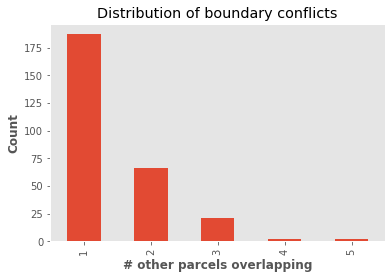

In [27]:
parcels_df['numConflicts'].value_counts().sort_values(ascending=False).plot(kind = 'bar', 
                                                                            title = 'Distribution of boundary conflicts',
                                                                            ylabel = "Count", 
                                                                            xlabel="# other parcels overlapping")

Text(0.5, 1.0, 'Area of overlap distribution')

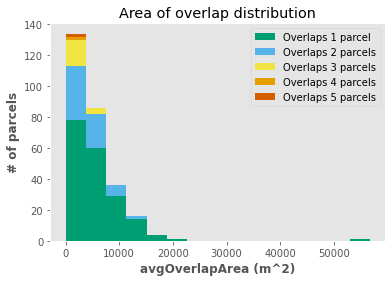

In [28]:

x1 = list(parcels_df[parcels_df['numConflicts'] == 1]['avgOverlapArea (m^2)'])
x2 = list(parcels_df[parcels_df['numConflicts'] == 2]['avgOverlapArea (m^2)'])
x3 = list(parcels_df[parcels_df['numConflicts'] == 3]['avgOverlapArea (m^2)'])
x4 = list(parcels_df[parcels_df['numConflicts'] == 4]['avgOverlapArea (m^2)'])
x5 = list(parcels_df[parcels_df['numConflicts'] == 5]['avgOverlapArea (m^2)'])

# Assign colors for each airline and the names
colors = [ '#009E73', '#56B4E9', '#F0E442', '#E69F00', '#D55E00']
names = ['Overlaps 1 parcel', 'Overlaps 2 parcels', 'Overlaps 3 parcels',
         'Overlaps 4 parcels', 'Overlaps 5 parcels']
         
# Make the histogram using a list of lists
plt.hist([x1, x2, x3, x4, x5], bins = int(15), stacked=True,
          color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('avgOverlapArea (m^2)')
plt.ylabel('# of parcels')
plt.title('Area of overlap distribution')

In [29]:
augmented_parcel_pairs_df

,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,intersectionGeometry,num_overlaps,centroid,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio
0,0,145,209,10460.257643,6551.586060,"(POLYGON ((30.9183838618845 1.22247203861534, ...",2,"(30.91846602788094, 1.2228639338567526)",333.14170,0.019583,0.050849
1,1,12,200,5779.323773,6899.731925,"(POLYGON ((30.9165724255 1.2178233407, 30.9165...",2,"(30.916563656440307, 1.2177656703567312)",36.16338,0.002852,0.006257
2,2,193,193,10527.350688,10527.350688,"POLYGON ((31.721682440144 1.83134607170577, 31...",1,"(31.721660528263076, 1.831678972875567)",10527.35069,0.500000,1.000000
3,3,115,115,6459.147904,6459.147904,"POLYGON ((31.7023454780717 1.83796144078034, 3...",1,"(31.702221684566112, 1.8378465495045102)",6459.14790,0.500000,1.000000
4,4,271,271,5706.377299,5706.377299,"POLYGON ((31.7061090397526 1.83877061457727, 3...",1,"(31.70555673784697, 1.838993491386797)",5706.37730,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
286,512,198,25,9311.059491,6076.672319,"(POLYGON ((31.7243889310715 1.83381242910344, ...",2,"(31.72428713347923, 1.8341155541300405)",189.57406,0.012320,0.031197
287,516,79,79,4737.942331,4737.942331,"POLYGON ((31.7259654270723 1.82984644426639, 3...",1,"(31.726458200686647, 1.8297065677382625)",4737.94233,0.500000,1.000000
288,517,25,25,6076.672319,6076.672319,"POLYGON ((31.7238548039268 1.83305197169427, 3...",1,"(31.7241422193294, 1.8336115800022497)",6076.67232,0.500000,1.000000
289,518,25,216,6076.672319,13871.731946,"POLYGON ((31.7238548039268 1.83305197169427, 3...",1,"(31.723920979446156, 1.833412948121746)",175.54081,0.008800,0.028888


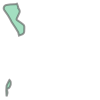

In [30]:
augmented_parcel_pairs_df["intersectionGeometry"][1]

In [31]:
type(augmented_parcel_pairs_df["intersectionGeometry"][1])

shapely.geometry.multipolygon.MultiPolygon

In [32]:
len(augmented_parcel_pairs_df["intersectionGeometry"][1])

2

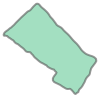

In [33]:
augmented_parcel_pairs_df["intersectionGeometry"][2]

<AxesSubplot:title={'center':'complex overlap distribution between any 2 intersections'}, xlabel='num of overlaps', ylabel='total pairs'>

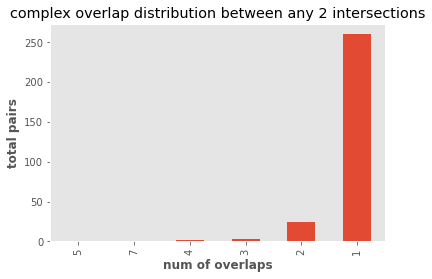

In [35]:
augmented_parcel_pairs_df['num_overlaps'].value_counts().sort_values().plot(kind = 'bar',
                                                                            title = 'complex overlap distribution between any 2 intersections',
                                                                            ylabel ="total pairs", xlabel="num of overlaps")

# Quantifying Overlaps & Recommendation

In [36]:
# Subject to change
# TODO : Potential for further analysis in figuring out the proper thresholds

THRESHOLD=30 #GPS related erroes 
OverlapWSmallTHRESHOLD=.99 #Delete the parcels with complete overlap

In [37]:
# Recommend what to do given a particular pair with some intersection

def categorizeOverlap(x):
    if x['IntersectionArea in m^2'] < THRESHOLD:
        return "IGNORE"
    elif x["OverlapToSmallRatio"] > OverlapWSmallTHRESHOLD:
        return "DELETE"
    elif x["num_overlaps"] > 2:
        return "REMAP"
    elif len(overlaps[x["parcel1Id"]]) > 2 or len(overlaps[x["parcel2Id"]]) > 2:
        return "REMAP"
    else:
        return "EDIT"

In [38]:
#Converting to geo data frame

pairs_geo = gpd.GeoDataFrame(augmented_parcel_pairs_df, geometry='intersectionGeometry',crs="EPSG:4326")
pairs_geo['overlap_cat'] = pairs_geo.apply(categorizeOverlap, axis=1)



In [45]:
pie_df = pd.DataFrame(pairs_geo['overlap_cat'].value_counts())
pie_df

,overlap_cat
DELETE,186
EDIT,38
REMAP,38
IGNORE,29


<AxesSubplot:title={'center':'Action recommended for the intersections'}, ylabel='overlap_cat'>

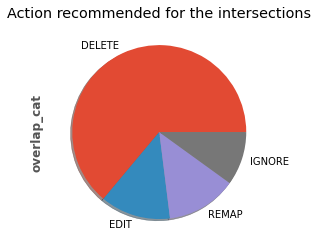

In [47]:
pairs_geo['overlap_cat'].value_counts().plot(kind = 'pie', shadow=True, title='Action recommended for the intersections')


In [48]:
edit_set = set()
delete_set = set()
remap_set = set()
ignore_set = set()

# TODO: Tag a given parcel rather than pair

edit_set.update(pairs_geo[pairs_geo['overlap_cat']=="EDIT"]["parcel1Id"].values)
edit_set.update(pairs_geo[pairs_geo['overlap_cat']=="EDIT"]["parcel2Id"].values)

delete_set.update(pairs_geo[pairs_geo['overlap_cat']=="DELETE"]["parcel1Id"].values)
delete_set.update(pairs_geo[pairs_geo['overlap_cat']=="DELETE"]["parcel2Id"].values)

remap_set.update(pairs_geo[pairs_geo['overlap_cat']=="REMAP"]["parcel1Id"].values)
remap_set.update(pairs_geo[pairs_geo['overlap_cat']=="REMAP"]["parcel2Id"].values)

ignore_set.update(pairs_geo[pairs_geo['overlap_cat']=="IGNORE"]["parcel1Id"].values)
ignore_set.update(pairs_geo[pairs_geo['overlap_cat']=="IGNORE"]["parcel2Id"].values)

In [49]:
def tagParcel(x):
    if x['parcelId'] in delete_set:
        return "DELETE"
    elif x['parcelId'] in remap_set:
        return "REMAP"
    elif x['parcelId'] in edit_set:
        return "EDIT"
    else:
        return "IGNORE"

## Visualising all the parcels on a map

In [51]:
import matplotlib
# pairs_geo.explore(column='overlap_cat', cmap=colors.ListedColormap(['#5bc0de','#f0ad4e', '#a0ad4e', '#d9534f']))
parcels_df_gpd = gpd.GeoDataFrame(parcels_df, geometry='geometry', crs="EPSG:4326")
parcels_df_gpd['Tag'] = parcels_df_gpd.apply(tagParcel, axis=1)
parcels_df_gpd.explore(column='Tag', cmap=matplotlib.colors.ListedColormap(['#5bc0de','#f0ad4e', '#a0ad4e', '#d9534f']),marker_type='marker',style_kwds={"fillOpacity":0.3}) 

In [52]:
pairs_geo[pairs_geo["pairId"]==22]

,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,intersectionGeometry,num_overlaps,centroid,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio,overlap_cat
15,22,210,217,18943.340563,36830.001323,"MULTIPOLYGON (((30.87094 1.22956, 30.87094 1.2...",2,"(30.871584019200917, 1.2297450186754975)",17203.10262,0.308447,0.908135,EDIT


In [54]:
# ## https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset#:~:text=EPSG%3A4326%20%2D%20WGS%2084%2C,including%20Google%20Maps%20and%20OpenStreetMap.
# # parcels_df.crs = "epsg:4326"
# # Calculate area
# # parcels_df["Area"] = parcels_df.to_crs(epsg=3347).area  # nprojecting to EPSG:3347 (the projected system in meters that Statistics Canada useshttps://epsg.io/3347)

# # Make plot
# fig = px.choropleth_mapbox(parcels_df, geojson=parcels_df.geometry, locations=parcels_df.parcelId, color="avgOverlapArea (m^2)",
#                            center={"lat": 0.993, "lon": 34.073}, zoom=10.5,
#                            mapbox_style="carto-positron")
# fig.update_layout(margin=dict(l=0, r=0, t=30, b=10))

In [55]:
parcels_df = parcels_df.astype({'area (m^2)': 'float64','avgOverlapArea (m^2)': 'float64'})
parcels_df.describe()

,area (m^2),avgOverlapArea (m^2)
count,2.780000e+02,278.000000
mean,1.889782e+05,4826.266498
std,3.020809e+06,5242.910287
min,3.841093e+00,0.352880
25%,4.052138e+03,807.403739
50%,6.385859e+03,4031.128885
75%,1.027604e+04,6789.447085
max,5.037463e+07,56713.738090


In [56]:
parcels_df.sort_values(by=["numConflicts","avgOverlapArea (m^2)"] , ascending=False)

,parcelId,geometry,centroid,area (m^2),perimeter (m),numConflicts,avgOverlapArea (m^2),Tag
176,176,"POLYGON ((33.98010 1.02693, 33.97797 1.02601, ...","(34.07378719747871, 0.993739212796191)",5.037463e+07,48474.368104,5,3716.753550,DELETE
116,116,"POLYGON ((31.35783 1.42884, 31.35783 1.42884, ...","(31.357888042908872, 1.4288555931459814)",1.586419e+02,52.529679,5,33.628958,REMAP
22,22,"POLYGON ((31.35782 1.42875, 31.35782 1.42875, ...","(31.357839303190783, 1.4288113583736026)",1.389994e+02,43.828742,4,54.415410,REMAP
197,197,"POLYGON ((31.35790 1.42884, 31.35791 1.42880, ...","(31.357848727316796, 1.4288159856682092)",1.025135e+02,38.205791,4,49.268313,REMAP
194,194,"POLYGON ((31.79344 1.82108, 31.79344 1.82108, ...","(31.79376439953779, 1.820594433812226)",1.522016e+04,509.362067,3,5800.810277,DELETE
...,...,...,...,...,...,...,...,...
147,147,"POLYGON ((34.00741 1.05930, 34.00741 1.05930, ...","(34.00780755322106, 1.0589790094887004)",6.350750e+03,322.739995,1,5.185990,IGNORE
267,267,"POLYGON ((31.35804 1.42885, 31.35804 1.42885, ...","(31.358027200000002, 1.4288473000000008)",3.841093e+00,6.958767,1,3.841090,IGNORE
134,134,"POLYGON ((31.35795 1.42884, 31.35795 1.42884, ...","(31.357958149999995, 1.4288348500000005)",5.018868e+00,8.022547,1,1.218310,IGNORE
61,61,"POLYGON ((30.87715 1.20468, 30.87714 1.20469, ...","(30.877327442959942, 1.2048370883439412)",8.794863e+03,482.665276,1,0.352880,IGNORE


In [57]:
augmented_parcel_pairs_df = augmented_parcel_pairs_df.astype({'pairId': 'int32','parcel1Id': 'int32', 'parcel2Id': 'int32'})
augmented_parcel_pairs_df.sort_values(by="IntersectionArea in m^2", ascending=True)


,pairId,parcel1Id,parcel2Id,Area1 in m^2,Area2 in m^2,intersectionGeometry,num_overlaps,centroid,IntersectionArea in m^2,OverlapToSumRatio,OverlapToSmallRatio
104,171,160,56,4229.161343,3709.418362,"POLYGON ((30.9144416768267 1.22264970455719, 3...",1,"(30.914441549992624, 1.22264751425448)",0.14280,0.000018,0.000038
101,168,112,61,13626.622736,8794.863453,"POLYGON ((30.8769225616398 1.20516156312321, 3...",1,"(30.876916395863887, 1.2051551925835586)",0.35288,0.000016,0.000040
201,328,191,241,6711.157529,4972.138188,"POLYGON ((31.7474992821954 1.80653994253038, 3...",1,"(31.74751935367469, 1.8065431408220773)",0.89996,0.000077,0.000181
32,47,134,116,5.018868,158.641939,"POLYGON ((31.3579463308569 1.42883845101375, 3...",1,"(31.357950601278166, 1.428833566094112)",1.21831,0.007444,0.242746
74,120,36,149,8445.536929,12952.190388,"POLYGON ((31.7944243185899 1.81989966822688, 3...",1,"(31.794426324868876, 1.81988713767956)",2.28441,0.000107,0.000270
...,...,...,...,...,...,...,...,...,...,...,...
5,5,244,244,21214.022911,21214.022911,"POLYGON ((31.1106479092029 1.40846582893791, 3...",1,"(31.111293721913242, 1.4088796664628724)",21214.02291,0.500000,1.000000
120,206,97,97,22196.313530,22196.313530,"POLYGON ((31.1320340214 1.4040699543, 31.13203...",1,"(31.13297423688049, 1.4043483929391403)",22196.31353,0.500000,1.000000
56,90,52,52,23686.736218,23686.736218,"POLYGON ((31.1137224026709 1.4013332311065, 31...",1,"(31.11487011070055, 1.4014797458068946)",23686.73622,0.500000,1.000000
50,78,76,76,28348.514271,28348.514271,"POLYGON ((31.1153316637085 1.41592294808621, 3...",1,"(31.115044434539392, 1.4168240714539417)",28348.51427,0.500000,1.000000


<AxesSubplot:ylabel='Frequency'>

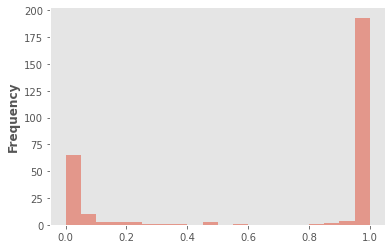

In [60]:
augmented_parcel_pairs_df['OverlapToSmallRatio'].plot.hist(bins=20, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

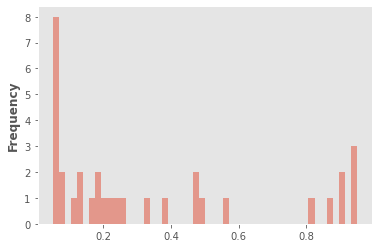

In [62]:
mid_df = augmented_parcel_pairs_df[(augmented_parcel_pairs_df["OverlapToSmallRatio"] < .95) & (augmented_parcel_pairs_df["OverlapToSmallRatio"] > 0.05)]
mid_df['OverlapToSmallRatio'].plot.hist(bins=50, alpha=0.5)